In [3]:
!python --version

Python 3.8.16


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import os

batch_size = 32 # split 0.8 : 9600 / 2400

![Texte alternatif…](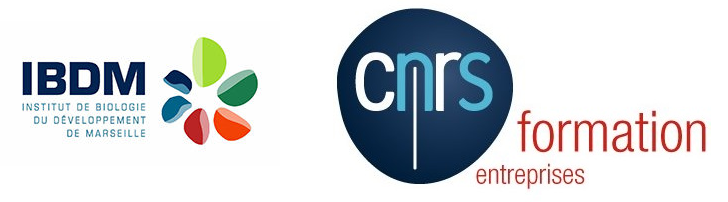
)

__"Automatisation du traitement d’images : du langage macro et jython (ImageJ,FIJI) à l’intelligence artificielle (DeepImageJ, Weka, Ilastik, Keras,Google Colab)"__

(25 - 29 Octobre 2021)

Fabrice Daian (CNRS - IBDM)

# TD2: Programmer un réseau de neurones convolutif avec Keras

***Objectif*** : Programmer un réseau de neurones convolutif pour la classification d'images avec Keras

***Compétences visées:*** 
- Découvrir et utiliser la librairie *ImageDataGenerator* de Keras 
- Apprendre à lire une architecture de réseau convolutif à partir d'un tableau
- Implémenter un réseau convolutif "from scratch"

***Liens utiles:*** [Keras](https://keras.io/)

## Jeu de données: MNIST

Le jeu de donnée MNIST consiste en une série de 60.000 images d'entrainement et de 10.000 images de tests. Les images sontde petite taille (28x28 pixels) et contiennent toutes un chiffre manuscrit de 0 à 9. Il est utilisé comme base d'évaluation d'algorithme d'apprentissage automatique pour la classification.

![MNIST](https://miro.medium.com/proxy/0*At0wJRULTXvyA3EK.png)

### <font color="red">Changer l'environnement d'exécution de CPU à GPU</font>

Comme nous allons travailler avec des réseaux un peu plus important et qui nécessitent un peu plus de puissance de calcul, nous allons changer l'environnement d'exécution de Google Colab afin de travailler sur GPU.

Pour cela, vous allez:
Dans le menu __Execution__, choisir __Modifier le type d'exécution__, et dans le menu déroulant __Acélérateur Matériel__ choisir l'option __GPU__ à la place de __None__, puis cliquez sur le bouton __Enregistrer__.

### Lecture des images avec Keras ImageDataGenerator

Téléchargeons les images que nous utiliserons pour l'entrainement et l'évaluation du modèle

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!ls '/content/gdrive/MyDrive'

 1541455032162-9pzxae9.png
'Colab Notebooks'
'Compte rendu NGS.gdoc'
'CR TP RNAseq.gdoc'
'Document sans titre (1).gdoc'
'Document sans titre.gdoc'
 env.RData
 M1-MEMOIRE-AlizadehNoiret_Gregoire_2021-2022.gdoc
 M1-PRESENTATION-AlizadehNoiret_Gregoire_2021-2022.pdf.gslides
 M1-PRESENTATION-AlizadehNoiret_Gregoire_2021-2022.pdf.pdf
 p500hp32.zip
 p500ht32.zip
 p500t32.zip
 poly_1000_het_png_32.zip
 poly_1000_hom_png_32.zip
 poly_real_data_size_het_png_60.zip
 poly_real_data_size.zip
 prediction_results
'présentation Sanofi - Graphique à secteurs 1.gsheet'
 projet_dl
 projet_s2


In [8]:
# Téléchargement et unzip des images
#!wget -O mnist.tar.gz https://amubox.univ-amu.fr/s/4fAXXBgG4Z2ZnMW/download -nv
#!tar -xzf mnist.tar.gz
#!rm -f mnist.tar.gz

#!unzip '/content/gdrive/MyDrive/projet_dl/poly_1000_hom_png_60.zip'
#!unzip '/content/gdrive/MyDrive/projet_dl/poly_1000_het_png_60.zip'
#!unzip '/content/gdrive/MyDrive/projet_dl/data_aug_new.zip'
#!unzip '/content/gdrive/MyDrive/projet_dl/sim_het.zip'

!unzip '/content/gdrive/MyDrive/projet_dl/vignettes_v0_triees.zip'
!unzip '/content/gdrive/MyDrive/projet_dl/vignettes_v1_triees.zip'
!unzip '/content/gdrive/MyDrive/projet_dl/aug_total.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: aug_total/4/4m (102).tif  
  inflating: aug_total/4/4m (103).tif  
  inflating: aug_total/4/4m (104).tif  
  inflating: aug_total/4/4m (105).tif  
  inflating: aug_total/4/4m (106).tif  
  inflating: aug_total/4/4m (107).tif  
  inflating: aug_total/4/4m (108).tif  
  inflating: aug_total/4/4m (109).tif  
  inflating: aug_total/4/4m (11).tif  
  inflating: aug_total/4/4m (110).tif  
  inflating: aug_total/4/4m (111).tif  
  inflating: aug_total/4/4m (112).tif  
  inflating: aug_total/4/4m (113).tif  
  inflating: aug_total/4/4m (114).tif  
  inflating: aug_total/4/4m (115).tif  
  inflating: aug_total/4/4m (116).tif  
  inflating: aug_total/4/4m (117).tif  
  inflating: aug_total/4/4m (118).tif  
  inflating: aug_total/4/4m (119).tif  
  inflating: aug_total/4/4m (12).tif  
  inflating: aug_total/4/4m (120).tif  
  inflating: aug_total/4/4m (121).tif  
  inflating: aug_total/4/4m (122).tif  
  in

En ouvrant le panel gauche et en cliquant sur __Fichiers__, vous devriez voir le répertoire __mnist_png__.

Ce répertoire contient 2 sous répertoires:
- __training__ qui contiendra les images que nous utiliserons pour entraîner notre modèle
- __testing__ qui contiendra les images que nous utiliserons pour tester notre modèle

Chacun de ses répertoires contient 10 autres sous répertoire:
- 0 : contient toutes les images représentant un "0"
- 1 : contient toutes les images représentant un "1"
- 2 : contient toutes les images représentant un "2"
- etc ...


### Keras ImageDataGenerator

Les __ImageDataGenerator__ de Keras vont nous permettre de lire les images sur le disque, de créer les batchs et d'appliquer toutes sorte de modification aux images comme la mise à l'échelle (scaling), l'augmentation de données...
([plus d'infos sur le site Keras](https://keras.io/preprocessing/image/#imagedatagenerator-class))

[Mini-cours sur les ImageDataGenerator](https://amubox.univ-amu.fr/s/NpkkXe7YSttEbAK/download)



```
# `Ce texte est au format code`
```

Commençons par charger la classe adéquat:

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Pour construire le **ImageDataGenerator**, nous avons besoin de lui fournir des paramètres pour lui indiquer:
- si les pixels doivent subir une quelconque normalisation
- quelle est la proportion d'images que l'on souhaite réserver pour le jeu de Test (ou de validation)

In [10]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

Explication:
- le paramètre **rescale** va indiquer à l'ImageDataGenerator, que la valeur de tous les pixels doivent être divisés par 255. Si nous travaillons avec des images 8-bit, toutes les valeurs de pixels seront automatiquement converties pour prendre des valeurs entre 0 et 1.

- Le paramètre **validation_split** va indiquer, comme nous l'avions fait avec le paramètre "test_size" de la fonction *train_test_split*, la proportion d'images que nous souhaiton réserver pour le jeu de validation.
Dans notre cas ici, nous réservons 20% du jeu global pour le jeu de validation et donc 80% pour le jeu d'entrainement.



Créons maintenant un premier **générateur** qui va permettre la lecture des images.

Nous devons également lui indiquer des paramètres précis pour qu'il puisse marcher:
- la localisation sur le disque du répertoire contenant le jeu de données
- la taille que nous souhaitons pour les images que nous lirons. Cette taille peut être différente de la taill réelle des images.
- la taille d'un batch (lot). Cela permet de signifier combien d'images devons nous lire en même temps pour le passer au réseau de neurones. Plus on prend une taille de batch importante, plus il est nécessaire d'avoir de la mémoire (car toutes les images d'un batch sont chargées en mémoire simultanément)
- le type d'images que nous lisons: en niveau de gris (grayscale), en couleur (rgb), ...
- le type de set que nous créons avec ce générateur: training/validation

Ici, nous créons un générateur qui va permettre de lire les images stockées dans le répertoire mnist_png/training/, on souhaite que toutes les images soient redimensionnées pour avoir une taille non plus de 28x28 pixels mais de 32x32 pixels. On veut lire par lot de 64 images, les images sont en niveau de gris et ce générateur doit être utilisé pour construire le set d'entraînement.

In [11]:
train_img_gen = datagen.flow_from_directory(
    #"./poly_1000_hom_png_60/training/",
    #"./poly_1000_het_png_60/training/",
    #"./data_annot/",
    #"./data_aug_new/aug_training/",
    #"./data_aug_total/",
    #"./aug_total/",
    #"./sim_1/",
    #"./vignettes_v0_triees/",
    "./vignettes_v1_triees/",
    target_size = (32,32),
    batch_size  = batch_size,
    color_mode  = "grayscale",
    subset      = "training"
)

Found 659 images belonging to 10 classes.


Nous devons maintenant créer un nouveau générateur identique, mais celui-ci au lieu de servir à construire le set d'entrainement, servira à construire le set de Test (ou de validation)

In [12]:
valid_img_gen = datagen.flow_from_directory(
    #"./poly_1000_hom_png_60/training/",
    #"./poly_1000_het_png_60/training/",
    #"./data_annot/",
    #"./data_aug_new/aug_training/",
    #"./data_aug_total/",
    #"./aug_total/",
    #"./sim_1/",
    #"./vignettes_v0_triees/",
    "./vignettes_v1_triees/",
    target_size = (32,32),
    batch_size  = batch_size,
    color_mode  = "grayscale",
    subset      = "validation"
)

Found 160 images belonging to 10 classes.


Afin de tester nos générateurs, on va leur demander de nous renvoyer un batch aléatoire d'images.

Pour cela nous allons utiliser la fonction Python __next__ qui va renvoyer deux Numpy Array que nous stockons dans deux variables:
- X : qui contiendra les images contenus dans le batch
- y : qui contiendra les labels contenus dans le batch et correspondant à chaque image du batch

Générons un batch d'image aléatoires sur le jeu d'entrainement

In [13]:
X,y = next(train_img_gen)

On peut faire afficher les caractéristiques de ce batch (Nombre d'images dans le batch, dimension des images)

In [14]:
X.shape

(32, 32, 32, 1)

On remarque que nous avons un batch de 64 images, qui ont une hauteur de 32 pixels, une largeur de 32 pixels, et qui sont en niveaux de gris (1 dans la dernière dimensions).

Cette structure comportant 4 dimensions s'appelle un **Tenseur**.

Faisons afficher les caractéristiques des cibles de ce batch:

In [15]:
y.shape

(32, 10)

Faison afficher le contenu de la variable y:

In [16]:
print(y)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0.

Pourquoi 10 colonnes ?

Car les cibles ont été automatiquement converties en catégories par l'ImageDataGenerator.



Visualisation du batch

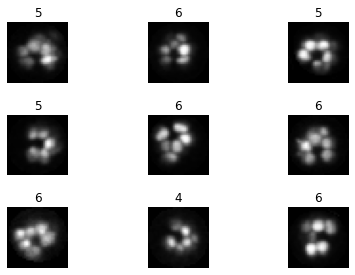

In [17]:
import matplotlib.pyplot as plt
import numpy as np

X,y = next(train_img_gen)
plt.subplots(nrows = 3,ncols = 3)
plt.tight_layout()

labels = []
for l in train_img_gen.class_indices.keys():
  labels.append(l)

k=1
for i in range(3):
  for j in range(3):
    plt.subplot(3,3,k)
    plt.imshow(np.squeeze(X[k-1]),cmap="gray")
    plt.axis("off")
    plt.title(labels[np.argmax(y[k-1])])
    k=k+1

plt.show()

### Construction du réseau de neurones convolutif

Les réseaux de neurones convolutifs sont un peu plus complexe à concevoir que les perceptrons multi-couches, mais grâce à Keras, nous allons voir que l'on peut très rapidement développé de tels réseaux.

Un réseau convolutif est composé de deux parties distinctes qui s'enchaine l'une après l'autres:

- une partie contenant les neurones convolutifs et chargé de l'__extraction de features__ à partir des images
- une partie contenant un perceptron multicouche prenant en entrée les features extraites par les couche convolutives et chargé de faire la classification.

Voici un tableau détaillant les layers du premier réseau de neurones convolutifs créé par Yann Lecun en 1998 : __LeNet5__


<center><b><u>Réseau convolutif LeNet5</b></u></center>

![Texte alternatif…](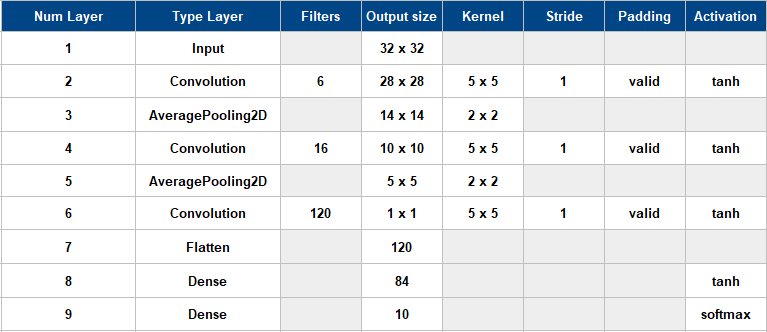
)

Et voici le code Keras pour le construire:

In [18]:
from tensorflow.keras.layers import Input,Conv2D,AveragePooling2D,Flatten,Dense
from tensorflow.keras.models import Model

# 1 - Couche d'entrée
inp = Input((32,32,1))

# 2 - Partie convolutive
conv1 = Conv2D( filters = 6, kernel_size = 5, strides = 1, padding="valid", activation="tanh") (inp)
avg1  = AveragePooling2D (pool_size = 2) (conv1)

conv2 = Conv2D( filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation="tanh") (avg1)
avg2  = AveragePooling2D (pool_size = 2) (conv2)

conv3 = Conv2D( filters = 120, kernel_size=5, strides = 1, padding="valid", activation="tanh") (avg2)

flat = Flatten() (conv3)

# 3 - Perceptron multicouche
fc1   = Dense(84, activation="tanh") (flat)

# 4 - Couche de sortie
out   = Dense(10, activation="softmax") (fc1)


model = Model(inputs = inp, outputs = out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120 

#### Compilation du modèle

Comme pour tous réseaux de neurones, nous devons utiliser un Optimizer, une fonction de loss et une métrique.

Le fait que nous utilisons un réseau de neurones convolutifs ne change rien à ce que nous utilisions dans les perceptron multicouche, nous réutilisons donc le même optimizer, fonction de loss de classification et métrique de classification:

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy

learning_coef = 5e-3

model.compile(Adam(learning_coef),categorical_crossentropy,categorical_accuracy)

### Entraînement du modèle

Ca y est, nous somme prêt à entrainer le modèle !


Nous allons utiliser la fonction __fit__ avec les paramètres suivants:

- le nom du générateur que nous avons créé pour le set d'entrainement: __train_img_gen__
- le nom du générateur que nous avon créé pour le set de validation: __valid_img_gen__ que nous passerons dans le paramètre __validation_data__
- le nombre d'epochs, fixons le à 10
- le paramètre __steps_per_epochs__ devra lui correspondre au nombre d'image dans le training set divisé par la taille de votre batch : 48004 // batch_size.
On peut accéder directement au nombre d'images dédié à l'entrainement du modèle en utilllisant la propriété: *train_img_gen.samples*

- le paramètre __validation_steps__ devra lui correspondre au nombre d'images dans le validation set divisé par la taille de votre batch: 11996 // batch_size
On peut accéder directement au nombre d'images dédié à la validation du modèle en utilllisant la propriété: *valid_img_gen.samples*




In [20]:
print(learning_coef)
H = model.fit(
    train_img_gen,
    validation_data =  (valid_img_gen),
    steps_per_epoch =  train_img_gen.samples // batch_size,
    validation_steps=  valid_img_gen.samples // batch_size,
    epochs=100
)

0.005
Epoch 1/100
20/20 [==============================] - 9s 37ms/step - loss: 1.3015 - categorical_accuracy: 0.5215 - val_loss: 0.9473 - val_categorical_accuracy: 0.6313
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 1.0308 - categorical_accuracy: 0.6188 - val_loss: 0.9751 - val_categorical_accuracy: 0.6562
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 1.0036 - categorical_accuracy: 0.5949 - val_loss: 0.9458 - val_categorical_accuracy: 0.6313
Epoch 4/100
20/20 [==============================] - 1s 33ms/step - loss: 0.9624 - categorical_accuracy: 0.6332 - val_loss: 0.9032 - val_categorical_accuracy: 0.6313
Epoch 5/100
20/20 [==============================] - 1s 40ms/step - loss: 0.9841 - categorical_accuracy: 0.6124 - val_loss: 0.8932 - val_categorical_accuracy: 0.6313
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 0.9683 - categorical_accuracy: 0.6172 - val_loss: 0.9139 - val_categorical_accuracy: 0.656

### Monitoring et évaluation du modèle

Affichons les courbes d'apprentissage:

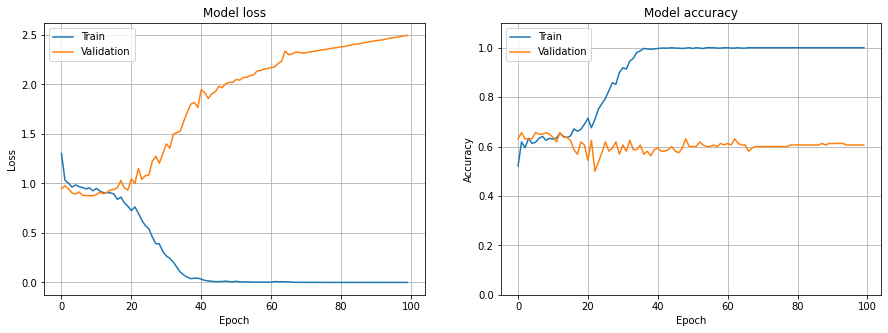

In [21]:
def learning_curves(H):
  # Plot training & validation loss values
  f = plt.figure(figsize=(15,5))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(H.history['loss'])
  ax.plot(H.history['val_loss'])
  ax.set_title('Model loss')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Validation'])
  ax.grid(True)

  # Plot training & validation accuracy values
  ax2.plot(H.history['categorical_accuracy'])
  ax2.plot(H.history['val_categorical_accuracy'])
  ax2.set_title('Model accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylim((0,1.1))
  ax2.legend(['Train', 'Validation'])
  ax2.grid(True)

learning_curves(H)

### Evaluation du modèle sur le jeu de test

Le jeu de test se trouve dans le repertoire __./mnist_png/testing__

Comme nous avons créer des générateurs pour des données d'entrainements et de validation, nous devons aussi créer un générateur pour le jeu de test en passant les bon paramètres. Pour cela, nous allons utiliser le même __ImageDataGenerator__ que pour les images d'entrainement et de validation, mais:
- nous n'allons pas préciser le type de subset pour éviter qu'il nous fasse le split, devenu inutile pour le test set, que nous avions défini tout à l'heure
- nous allons préciser le nom du répertoire père contenant les images du Test set
- nous allons enfin lui préciser que nous ne voulons pas prendre des images aléatoirement mais que nous voulons faire le test sur TOUTES les images. Pour cela on va utiliser le paramètre **shuffle** que l'on va déclarer avec la valeur *False*.



In [22]:
test_img_gen = datagen.flow_from_directory(
    #"./poly_1000_hom_png_60/testing/",
    #"./poly_1000_het_png_60/testing/",
    #"./data_annot/",
    #"./data_aug_new/aug_testing/",
    #"./data_aug_new/aug_testing/",
    #"./aug_total/",
    #"./sim_1/",
    #"./vignettes_v0_triees/",
    "./vignettes_v1_triees/",
    target_size = (32,32),
    shuffle=False,
    batch_size=batch_size,
    color_mode  = "grayscale",
)

Found 819 images belonging to 10 classes.


Maintenant que notre générateur est en place, nous allons faire l'évaluation de notre modèle.

In [23]:
LOSS,ACC = model.evaluate(test_img_gen)

print("Loss on Test set: ", LOSS)
print("Accuracy on Test set", ACC)

26/26 [==============================] - 0s 16ms/step - loss: 0.4877 - categorical_accuracy: 0.9231
Loss on Test set:  0.48770853877067566
Accuracy on Test set 0.9230769276618958


L'accuracy est assez similaire à ce que l'on avait sur le set de validation et le set d'entrainement, on peut donc en conclure que notre modèle est un modèle robuste qui sera performant sur des données qu'il rencontrera en production.

### Visualisation du résultat

Nous allons utiliser notre modèle sur un batch aléatoire du jeu de test pour récuperer les prédictions

In [24]:
real_ys, pred_ys = [], []

mon_bool = True
# Pour chaque lot d'images
for k in range(test_img_gen.samples // batch_size):
  mon_bool = False

  X0,y0 = next(test_img_gen)
  #print(y0)
  y_pred = model.predict(X0)
  for i in range(len(y_pred)):
    y = list(y_pred[i]) # y : probabilités d'appartenance à chaque classe
    pred_class = y.index(max(y)) # on définit la prédiction comme la classe la plus probable
    pred_ys.append(pred_class)
    real_ys.append(list(y0[i]).index(max(list(y0[i]))))

real_vs_pred = zip(real_ys, pred_ys)
real_vs_pred = sorted(real_vs_pred, key=lambda x:x[0])
print(real_vs_pred[:3])
d_real_vs_pred = {}
for real_class, pred_class in real_vs_pred:
  #print(real_class, pred_class)
  try:
    d_real_vs_pred[str(real_class)].append(pred_class)
  except:
    d_real_vs_pred[str(real_class)] = [pred_class]

1/1 [==============================] - 0s 13ms/step
[(1, 1), (2, 2), (2, 2)]


In [25]:
print(len(real_ys), len(pred_ys))
#print(len(d_real_vs_pred))
for key in d_real_vs_pred:
  print(key, d_real_vs_pred[key][:30])

800 800
1 [1]
2 [2, 2, 2, 2]
3 [5, 6, 6, 4, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
4 [6, 4, 5, 5, 6, 4, 6, 5, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
5 [6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 6, 6, 6, 5, 5, 5]
6 [6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6]


In [26]:
real_vs_pred = np.column_stack((real_ys, pred_ys))

In [27]:
print(sqrt(mean_squared_error(real_ys, pred_ys)))

0.39210967853395307


In [28]:
x = 0
for tpl in real_vs_pred:
  if tpl[1] == 6:
    x += 1
print(x)

500


In [29]:
def prop_correct(mylist, ref):
  sum = 0
  for element in mylist:
    if element == ref:
      sum += 1
  return sum/len(mylist)

def n_equal(mylist, ref):
  sum = 0
  for element in mylist:
    try:
      if element == ref:
        sum += 1
    except:
      pass
  return sum

In [35]:
os.listdir('vignettes_v1_triees/2')

['284.PNG', '302.PNG', '534.PNG', '279.PNG']

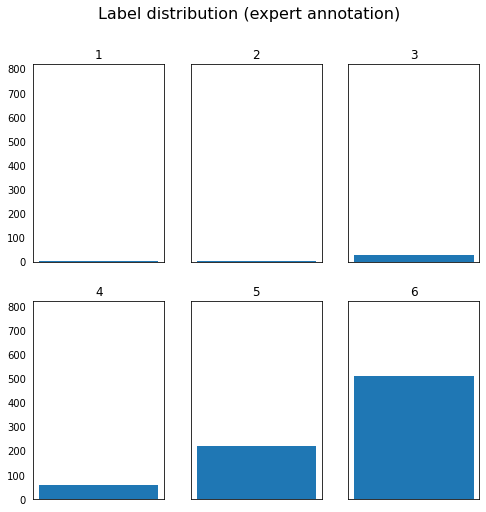

In [53]:
def get_sizes(image_dir, labels_list):
  sizes = {}
  for image_label in labels_list:
    sizes[image_label] = len(os.listdir(str(image_dir)+'/'+str(image_label)))
  return sizes

sizes = get_sizes('vignettes_v1_triees', [str(i) for i in range(10)])

n_images = sum([sizes[key] for key in sizes])

fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=3)
fig.suptitle('Label distribution (expert annotation)', fontsize=16)
for i in range(1, 7):
  current_ax = ax[(i-1)//3][(i-1)%3]
  current_ax.tick_params(left = False, right = False, labelleft = ((i-1)%3 == 0), labelbottom = False, bottom = False)
#  for j in range(1, 7):
#    col = ['g' if i == j else 'r']
#    if str(i) in d_real_vs_pred:
#      current_ax.bar(j, n_equal(d_real_vs_pred[str(i)], j), color=col)
#    else:
#      current_ax.bar(j, 0, color=col)
  current_ax.bar(i, sizes[str(i)])
  current_ax.set_title(f'{str(i)}')
#  current_ax.set_xticks([k for k in range(1, 7)])
#  if str(i) in d_real_vs_pred:
#    current_ax.set_ylim((0,len(d_real_vs_pred[str(i)])))
#  else:
  current_ax.set_ylim((0,n_images))

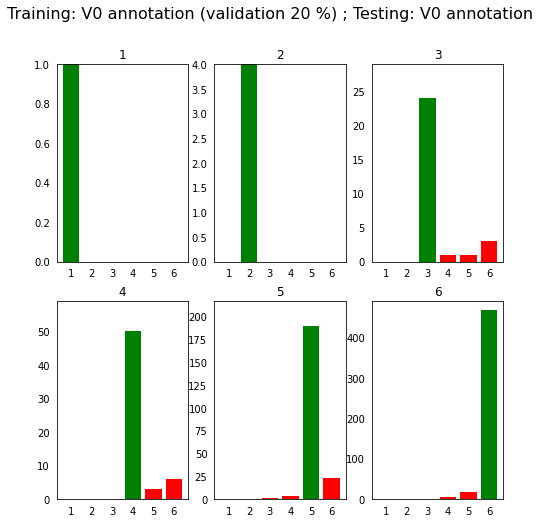

In [32]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=3)
fig.suptitle('Training: V0 annotation (validation 20 %) ; Testing: V0 annotation ', fontsize=16)
for i in range(1, 7):
  current_ax = ax[(i-1)//3][(i-1)%3]
  #current_ax.tick_params(left = False, right = False, labelleft = ((i-1)%3 == 0), labelbottom = True, bottom = False)
  current_ax.tick_params(left = False, right = False, labelleft = True, labelbottom = True, bottom = False)
  for j in range(1, 7):
    col = ['g' if i == j else 'r']
    if str(i) in d_real_vs_pred:
      current_ax.bar(j, n_equal(d_real_vs_pred[str(i)], j), color=col)
    else:
      current_ax.bar(j, 0, color=col)
  current_ax.set_title(f'{str(i)}')
  current_ax.set_xticks([k for k in range(1, 7)])
  if str(i) in d_real_vs_pred:
    current_ax.set_ylim((0,len(d_real_vs_pred[str(i)])))
  else:
    current_ax.set_ylim((0,0))

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(real_ys, pred_ys)

array([[  1,   0,   0,   0,   0,   0],
       [  0,   4,   0,   0,   0,   0],
       [  0,   0,  24,   1,   1,   3],
       [  0,   0,   0,  50,   3,   6],
       [  0,   0,   1,   3, 190,  23],
       [  0,   0,   0,   4,  18, 468]])

In [104]:
print(accuracy_score(real_ys, pred_ys))

0.8472222222222222


In [105]:
X0,y0 = next(test_img_gen)
y_pred = model.predict(X0)

1/1 [==============================] - 0s 19ms/step


In [106]:
import pickle

#pickle.dump(model, open('/content/gdrive/MyDrive/projet_dl/model_save.pickle', 'wb'))

#model_load = pickle.load(open('/content/gdrive/MyDrive/projet_dl/model_save.pickle', 'rb'))

In [107]:
model_load

Et nous faisons afficher 9 images aléatoires de ce batch

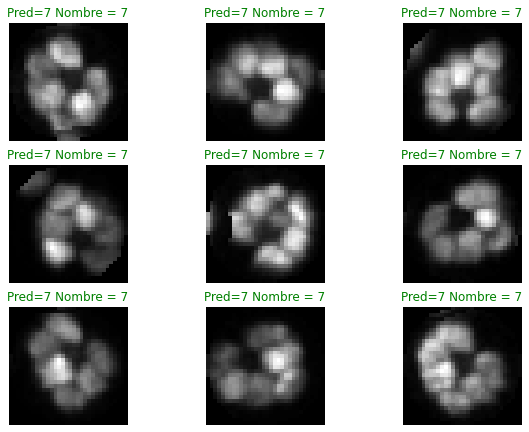

In [108]:
import random

def visualisation_predictions(X0,y0,y_pred):
  images = []
  images = random.sample(list(range(X0.shape[0])),9)


  f = plt.figure(figsize=(10,10))
  for i in range(9):
    ax = f.add_subplot(431+i)
    ax.imshow(X0[images[i],0:32,0:32,0],cmap="gray")
    title_obj = ax.set_title("Pred=" +str(np.argmax(y_pred[images[i]]))+" Nombre = "+str(np.argmax(y0[images[i]])))
    plt.axis("off")
    if (np.argmax(y_pred[images[i]])!=np.argmax(y0[images[i]])):
      plt.setp(title_obj, color='r')
    else:
      plt.setp(title_obj, color='g')

visualisation_predictions(X0,y0,y_pred)


In [109]:
X0.shape

(22, 32, 32, 1)

In [110]:
import os
try:
  os.mkdir('/content/gdrive/MyDrive/prediction_results')
except:
  pass
for i in range(1,10):
  try:
    os.mkdir('/content/gdrive/MyDrive/prediction_results/'+str(i))
  except:
    pass

### Visualiser les noyaux de convolution de la première couche et les images sortantes de chacune des couches convolutives

Voici un bout de code pour afficher les 6 noyaux de convolutions (filtres) de la première couche convolutive qui ont été appris par notre réseau de neurone:

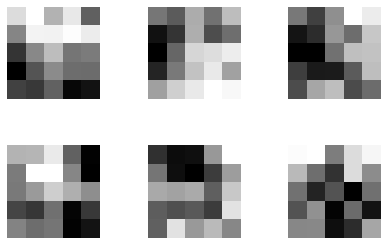

In [111]:
#On récupère les noyaux
noyau = np.squeeze(model.layers[1].get_weights()[0])

#On les affiche
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(noyau[:,:,k-1]),cmap="gray")
    plt.axis("off")
    k=k+1
plt.show()


On peut également voir le résultat du produit de convolution entre une image donnée et les 6 noyaux de la première couche convolutive:

Après la première couche convolutive


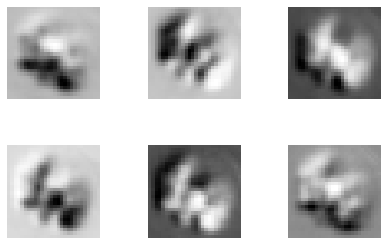

In [112]:
import tensorflow.keras.backend as K
#On crée un modèle ne contenant que les layers 0 et 1
to_layer=1
functor = K.function([model.layers[0].input],[model.layers[to_layer].output])
X,_ = next(test_img_gen)
output = functor([X])[0]

print('Après la première couche convolutive')
#On affiche les images sortant de la première couche convolutive
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(output)[0,:,:,k-1],cmap="Greys")
    plt.axis("off")
    k=k+1
plt.show()


On peut faire afficher les sorties après chaque layers du réseau convolutif:

Après le premier layer de convolution (C1)


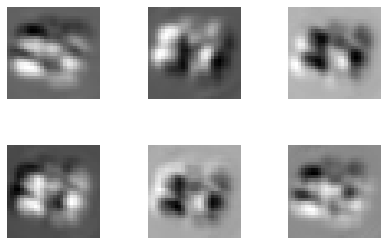

Après le premier layer de Pooling (S1)


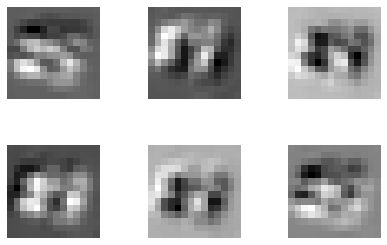

Après la seconde couche convolutive (C3)


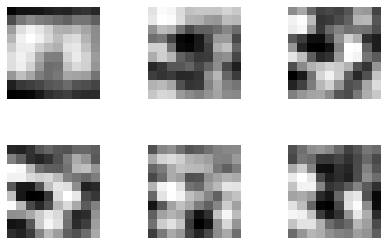

Après la seconde couche de Pooling (S4)


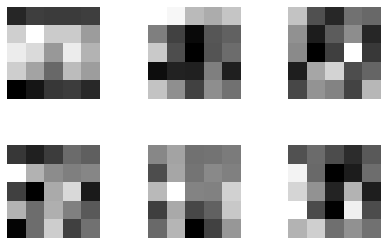

In [113]:
#@title Executez cette cellule !
to_layer=1
functor = K.function([model.layers[0].input],[model.layers[to_layer].output])
X,_ = next(test_img_gen)
output = functor([X])[0]

print('Après le premier layer de convolution (C1)')
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(output)[0,:,:,k-1],cmap="gray")
    plt.axis("off")
    k=k+1
plt.show()

to_layer=2
functor = K.function([model.layers[0].input],[model.layers[to_layer].output])
output = functor([X])[0]

print('Après le premier layer de Pooling (S1)')
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(output)[0,:,:,k-1],cmap="gray")
    plt.axis("off")
    k=k+1
plt.show()

to_layer=3
functor = K.function([model.layers[0].input],[model.layers[to_layer].output])
output = functor([X])[0]

print('Après la seconde couche convolutive (C3)')
#On affiche les images sortant de la première couche convolutive
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(output)[0,:,:,k-1],cmap="gray")
    plt.axis("off")
    k=k+1
plt.show()

to_layer=4
functor = K.function([model.layers[0].input],[model.layers[to_layer].output])
output = functor([X])[0]

print('Après la seconde couche de Pooling (S4)')
#On affiche les images sortant de la première couche convolutive
plt.subplots(nrows = 2,ncols = 3)
plt.tight_layout()
k=1
for i in range(2):
  for j in range(3):
    plt.subplot(2,3,k)
    plt.imshow(np.squeeze(output)[0,:,:,k-1],cmap="gray")
    plt.axis("off")
    k=k+1
plt.show()

## --

<font color="green">__Notebook License__</font>

Copyright 2021 Fabrice Daian

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.